In [2]:
import numpy as np
import pandas as pd 
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Training set


In [3]:
df_train = pd.read_csv("./data/kaggle/train.csv")
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


* id: ID của hàng
* qid{1,2}: ID của mỗi câu hỏi
* question{1, 2}: Nội dung đầy đủ của câu hỏi
* is_duplicate: Nhãn

In [4]:
print("Total number of question pairs for training: {}".format(len(df_train)))
print("Duplicate pairs: {} %".format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].to_list() + df_train['qid2'].to_list())
print('Total number of question in training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts()>1)))

Total number of question pairs for training: 404290
Duplicate pairs: 36.92 %
Total number of question in training data: 537933
Number of questions that appear multiple times: 111780


/home/thang/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Number of question')

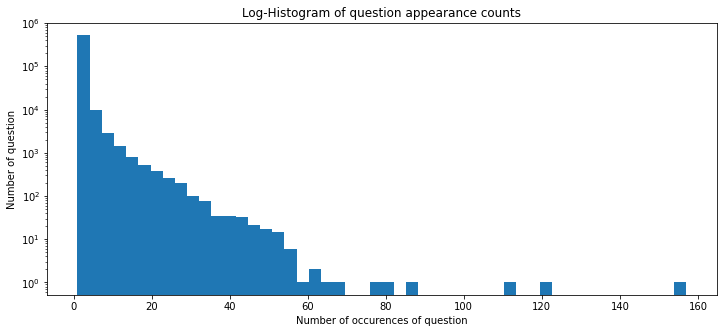

In [7]:
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of question')

# Test set

In [8]:
df_test = pd.read_csv('./data/kaggle/test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [9]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796


# Text analysis

In [10]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

Text(0, 0.5, 'Probability')

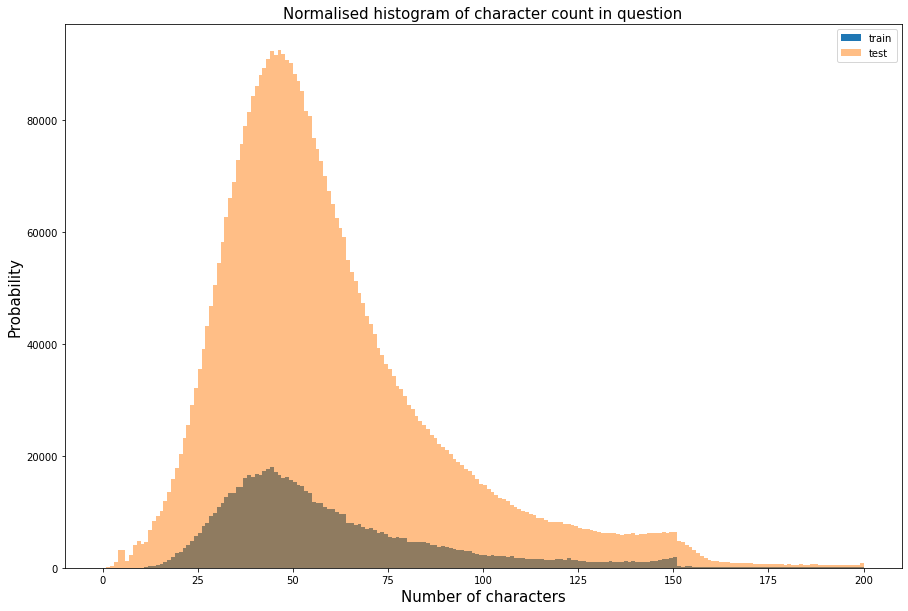

In [16]:
dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200],  label='train')
plt.hist(dist_test, bins=200, range=[0, 200], alpha=0.5, label='test')
plt.title('Normalised histogram of character count in question', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Text(0, 0.5, 'Probability')

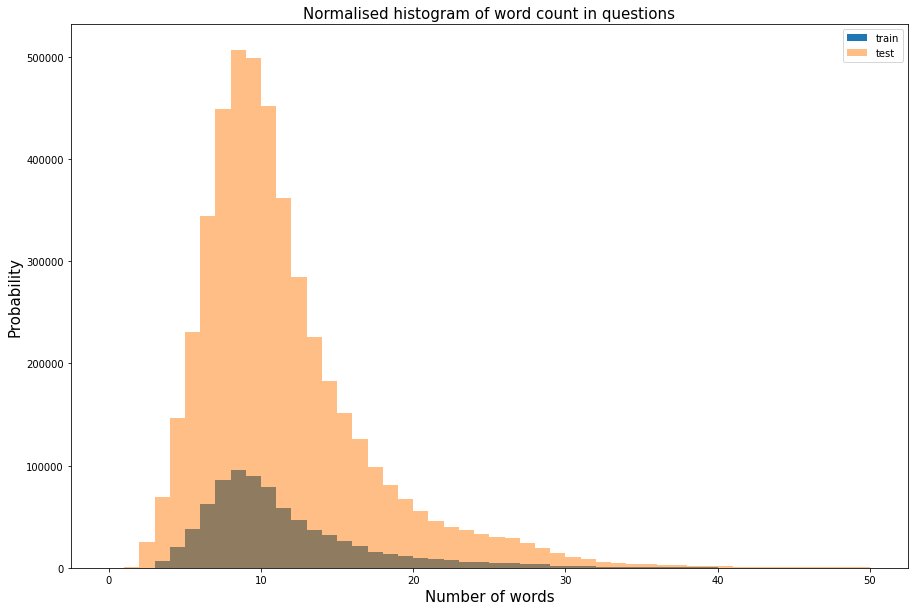

In [18]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50],label='train')
plt.hist(dist_test, bins=50, range=[0, 50], alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

(-0.5, 1439.5, 1079.5, -0.5)

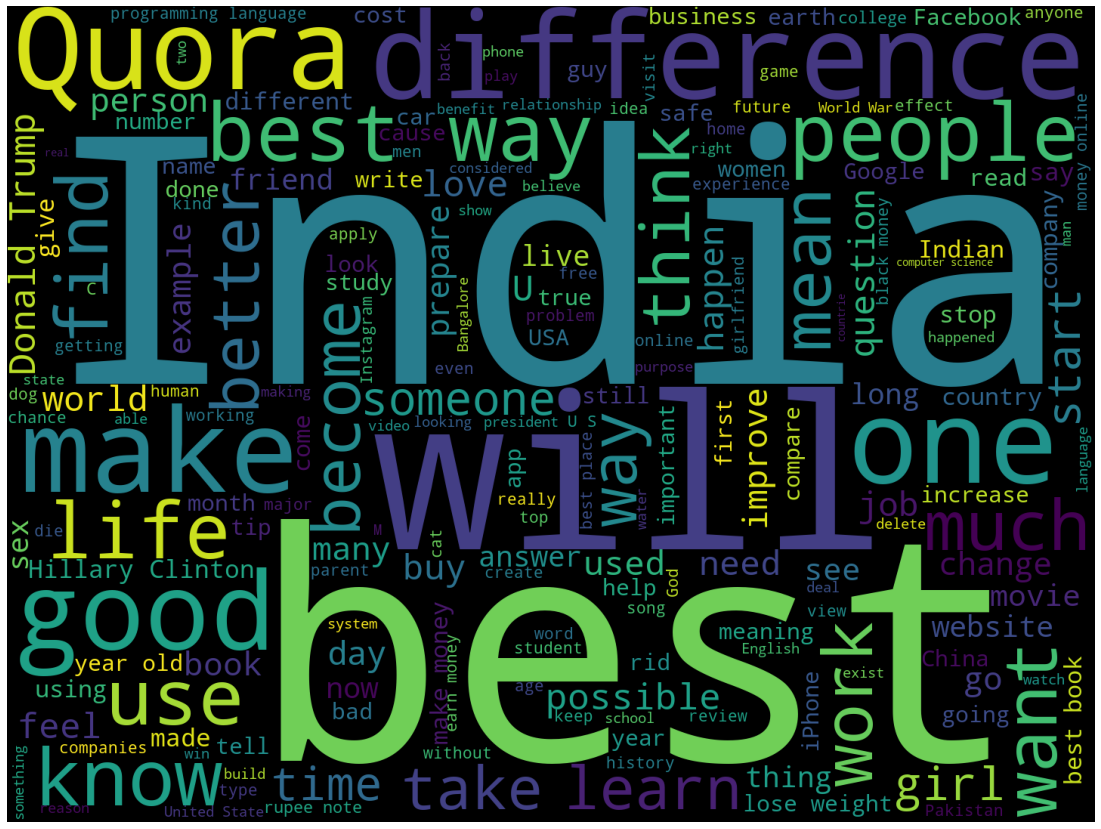

In [20]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# Sematic Analysis

In [24]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in  x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
captitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks {:.2f} %'.format(qmarks*100))
print('Questions with [math] tags: {:.2f} %'.format(math * 100))
print('Questions with full stops: {:.2f} %'.format(fullstop *100))
print('Questions with capitalised first letters: {:.2f} %'.format(capital_first * 100))
print('Questions with capital lettels: {:.2f} %'.format(captitals * 100))
print('Questions with numbers: {:.2f} %'.format(numbers * 100))

Questions with question marks 99.87 %
Questions with [math] tags: 0.12 %
Questions with full stops: 6.31 %
Questions with capitalised first letters: 99.81 %
Questions with capital lettels: 99.95 %
Questions with numbers: 11.83 %


# Initial Feature Analysis

In [28]:
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

Text(0.5, 0, 'word_match_share')

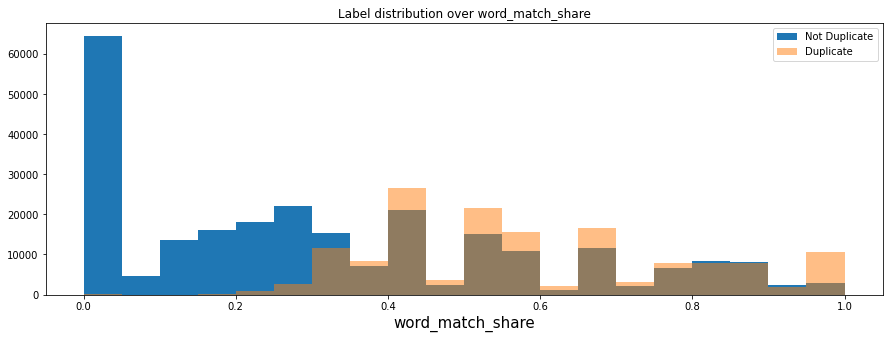

In [31]:
plt.figure(figsize=(15,5))
train_word_match = df_train.apply(word_match_share, axis=1)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, alpha = 0.5, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share')
plt.xlabel('word_match_share', fontsize=15)

Đặc trưng này hữu ích, khá tốt cho việc dự đoán các câu là khác nhau, nhưng chưa đủ tốt để dự đoán các câu là giống nhau.

# TF-IDF

In [32]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [33]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [34]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/home/thang/env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0, 'word_match_share')

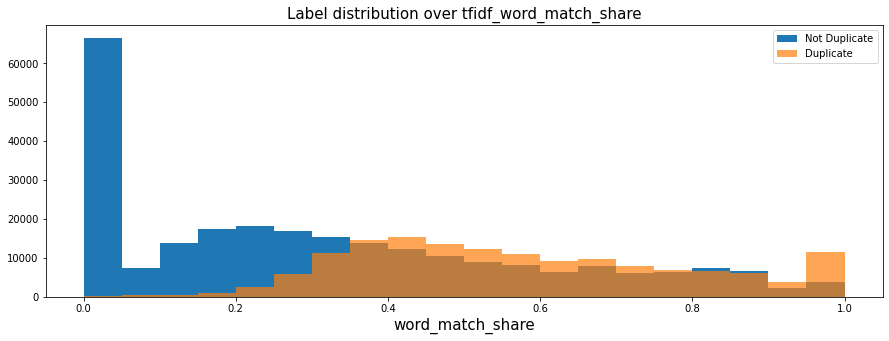

In [37]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [38]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


Vì vậy, có vẻ như TF-IDF của chúng tôi thực sự trở nên tồi tệ hơn về AUC tổng thể, điều này hơi đáng thất vọng.  (Tôi đang sử dụng số liệu AUC vì nó không bị ảnh hưởng bởi việc mở rộng quy mô và tương tự, vì vậy nó là một số liệu tốt để kiểm tra khả năng dự đoán của các tính năng riêng lẻ.

Tuy nhiên, tôi vẫn nghĩ rằng tính năng này sẽ cung cấp một số thông tin bổ sung mà tính năng gốc không cung cấp.  Công việc tiếp theo của chúng ta là kết hợp các tính năng này và sử dụng nó để đưa ra dự đoán.  Đối với điều này, tôi sẽ sử dụng người bạn cũ XGBoost của chúng tôi để làm mô hình phân loại.

# Rebalancing the Data

Tuy nhiên, trước khi thực hiện việc này, tôi muốn cân bằng lại dữ liệu mà XGBoost nhận được, vì chúng tôi có 37% lớp tích cực trong dữ liệu đào tạo của mình và chỉ 17% trong dữ liệu thử nghiệm.  Bằng cách cân bằng lại dữ liệu để tập hợp đào tạo của chúng tôi có 17% ​​khả năng tích cực, chúng tôi có thể đảm bảo rằng XGBoost đưa ra các xác suất sẽ phù hợp hơn với dữ liệu trên bảng thành tích và sẽ đạt điểm cao hơn (vì LogLoss tự xem xét các xác suất chứ không chỉ  thứ tự của các dự đoán như AUC)

In [45]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1)
y_train = df_train['is_duplicate'].values

/home/thang/env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/thang/env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [46]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this ...and
p = 0.165
scale = ((len(pos_train)/(len(pos_train)+len(neg_train)))/p)-1
print(scale)
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -= 1

neg_train = pd.concat([neg_train, neg_train[:int(scale*len(neg_train))]])
print(len(pos_train)/(len(pos_train)+len(neg_train)))


1.237562745613897
0.19124366100096607


In [47]:
x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

In [49]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

# XGBoost

In [51]:
import xgboost as xgb

In [52]:
# Set parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label= y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68307	valid-logloss:0.68331
[10]	train-logloss:0.60214	valid-logloss:0.60257
[20]	train-logloss:0.54522	valid-logloss:0.54585
[30]	train-logloss:0.50347	valid-logloss:0.50444
[40]	train-logloss:0.47210	valid-logloss:0.47355
[50]	train-logloss:0.44883	valid-logloss:0.45003
[60]	train-logloss:0.43054	valid-logloss:0.43200
[70]	train-logloss:0.41651	valid-logloss:0.41806
[80]	train-logloss:0.40519	valid-logloss:0.40710
[90]	train-logloss:0.39663	valid-logloss:0.39854
[100]	train-logloss:0.38979	valid-logloss:0.39181
[110]	train-logloss:0.38458	valid-logloss:0.38643
[120]	train-logloss:0.38004	valid-logloss:0.38219
[130]	train-logloss:0.37673	valid-logloss:0.37883
[140]	train-logloss:0.37414	valid-logloss:0.37614
[150]	train-logloss:0.37199	valid-logloss:0.37400
[160]	train-logloss:0.37022	valid-logloss:0.37224
[170]	train-logloss:0.36877	valid-logloss:0.37089
[180]	train-logloss:0.36765	valid-logloss:0.36977
[190]	train-logloss:0.36675	valid-logloss:0.36889
[200]	train

In [53]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('./models/simple_xgb.csv', index=False)